In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import butter, filtfilt

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["image.aspect"] = "auto"

In [10]:
# CHANGE THIS:
radar_path = "../dataset/Task1/Recorded/train/14-212-0024_recorded_aligned.wav"
clean_path = "../dataset/Task1/Clean/train/14-212-0024.wav"

x, sr = librosa.load(radar_path, sr=None)
print(f"Radar shape: {x.shape}, sr = {sr}")
y, sr = librosa.load(clean_path, sr=None)
print(f"Clean shape: {y.shape}, sr = {sr}")

Radar shape: (51200,), sr = 8000
Clean shape: (51200,), sr = 8000


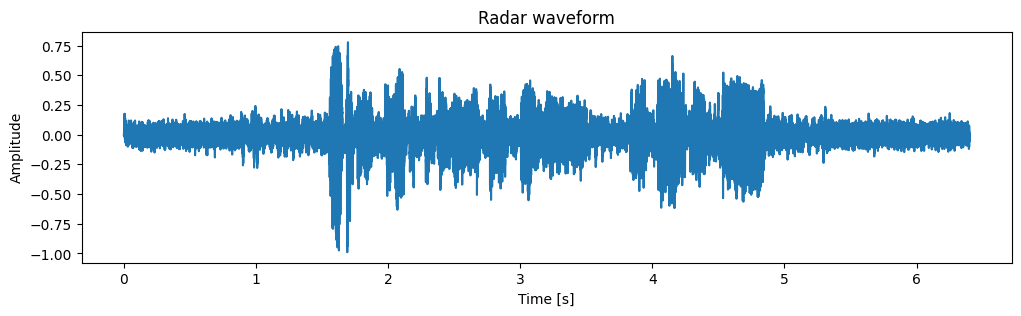

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(x)) / sr, x)
plt.title("Radar waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

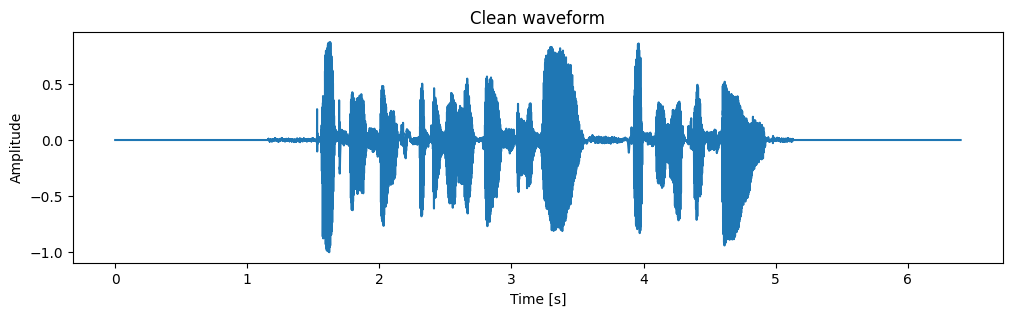

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(y)) / sr, y)
plt.title("Clean waveform")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

### Helper functions

In [ ]:
def butter_filter(x, sr, low=None, high=None, order=4):
    """Band/low/high-pass using Butterworth."""
    from scipy.signal import butter, filtfilt

    nyq = 0.5 * sr
    if low is not None and high is not None:
        btype = "band"
        Wn = [low / nyq, high / nyq]
    elif low is not None:
        btype = "high"
        Wn = low / nyq
    elif high is not None:
        btype = "low"
        Wn = high / nyq
    else:
        return x

    b, a = butter(order, Wn, btype=btype, analog=False)
    return filtfilt(b, a, x)


def compute_spec(x, sr, n_fft=512, hop_ms=10, win_ms=25, log=True, norm=True):
    """STFT + log + optional per-utterance normalization."""
    hop_length = int(sr * hop_ms / 1000)
    win_length = int(sr * win_ms / 1000)

    S = librosa.stft(x, n_fft=n_fft,
                     hop_length=hop_length,
                     win_length=win_length,
                     window="hann",
                     center=True)
    S_mag = np.abs(S)

    if log:
        S_mag = np.log1p(S_mag)

    if norm:
        m = S_mag.mean()
        s = S_mag.std() + 1e-6
        S_mag = (S_mag - m) / s

    return S_mag, hop_length


def plot_spec(S, sr, hop_length, title="Spectrogram", vmin=None, vmax=None):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(
        S,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="linear",
    )
    plt.title(title)
    if vmin is not None or vmax is not None:
        plt.clim(vmin, vmax)
    plt.colorbar(format="%+0.2f")
    plt.show()

    

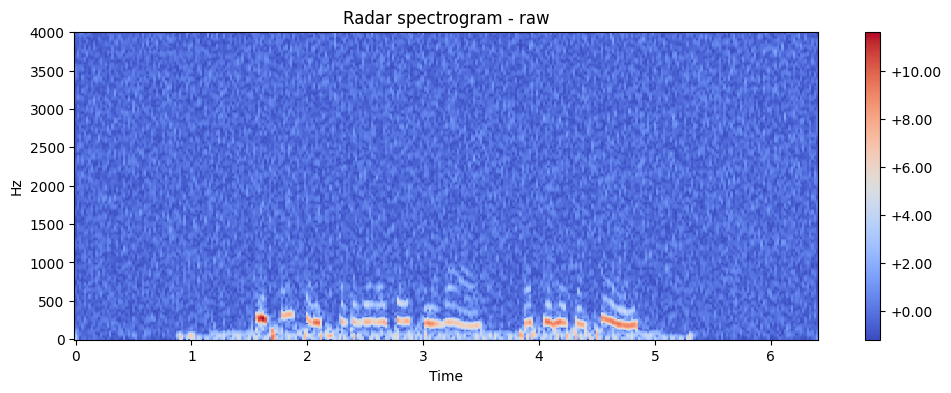

In [22]:
S_raw, hop_raw = compute_spec(x, sr,
                              n_fft=512,
                              hop_ms=20,
                              win_ms=25,
                              log=True,
                              norm=True)
plot_spec(S_raw, sr, hop_raw, title="Radar spectrogram - raw")

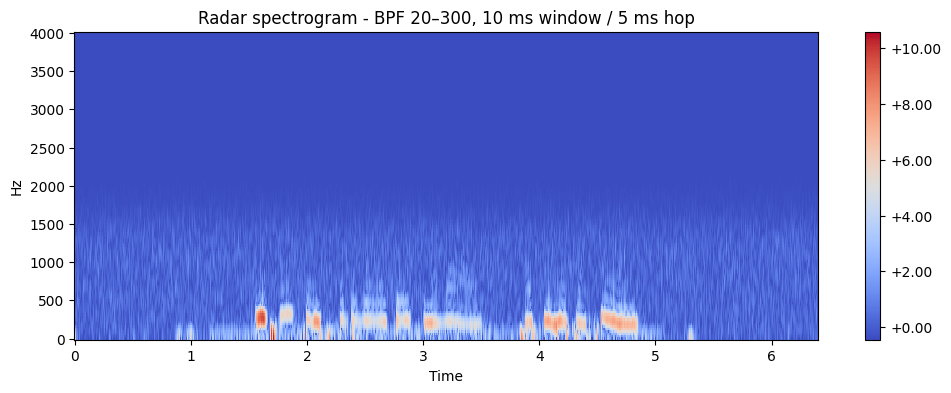

In [29]:
S_short, hop_short = compute_spec(x_bpf, sr,
                                  n_fft=256,
                                  hop_ms=5,
                                  win_ms=10,
                                  log=True,
                                  norm=True)
plot_spec(S_short, sr, hop_short,
          title="Radar spectrogram - BPF 20–300, 10 ms window / 5 ms hop")

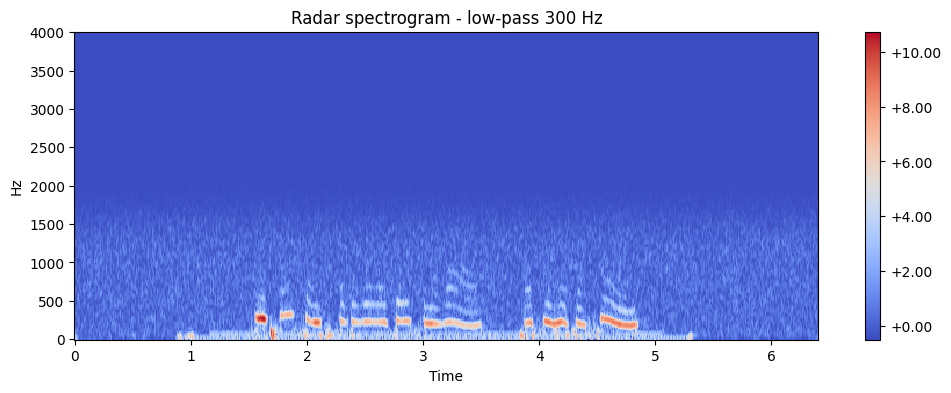

In [30]:
x_lpf = butter_filter(x, sr, low=None, high=1500, order=4)

S_lpf, hop_lpf = compute_spec(x_lpf, sr,
                              n_fft=512,
                              hop_ms=10,
                              win_ms=25,
                              log=True,
                              norm=True)
plot_spec(S_lpf, sr, hop_lpf, title="Radar spectrogram - low-pass 300 Hz")

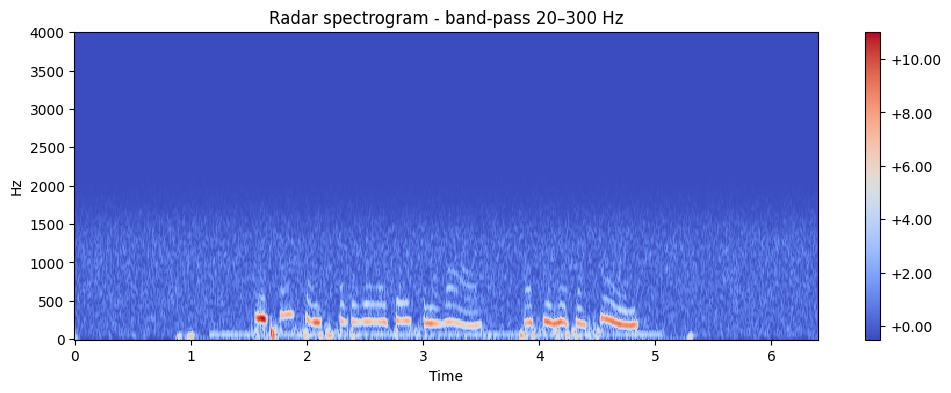

In [38]:
x_bpf = butter_filter(x, sr, low=20, high=1500, order=4)

S_bpf, hop_bpf = compute_spec(x_bpf, sr,
                              n_fft=512,
                              hop_ms=10,
                              win_ms=25,
                              log=True,
                              norm=True)
plot_spec(S_bpf, sr, hop_bpf, title="Radar spectrogram - band-pass 20–300 Hz")

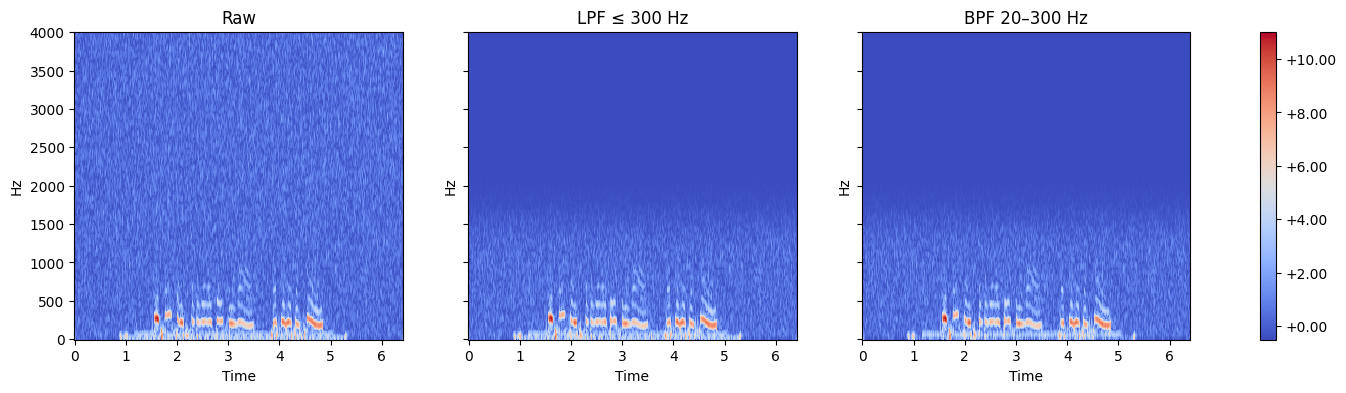

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

for ax, S, hop, title in [
    (axes[0], S_raw, hop_raw, "Raw"),
    (axes[1], S_lpf, hop_lpf, "LPF ≤ 1500 Hz"),
    (axes[2], S_bpf, hop_bpf, "BPF 20–1500 Hz"),
]:
    img = librosa.display.specshow(
        S,
        sr=sr,
        hop_length=hop,
        x_axis="time",
        y_axis="linear",
        ax=ax,
    )
    ax.set_title(title)

fig.colorbar(img, ax=axes, format="%+0.2f")
plt.show()

In [35]:
def inspect_radar(radar_path):
    x, sr = librosa.load(radar_path, sr=None)
    print(f"Loaded {radar_path}, len={len(x)/sr:.2f}s, sr={sr}")
    
    variants = {}
    variants["raw"] = x
    variants["lpf_1500"] = butter_filter(x, sr, low=None, high=1500, order=4)
    variants["bpf_20_1500"] = butter_filter(x, sr, low=20, high=1500, order=4)
    variants["clean"] = y

    
    for name, sig in variants.items():
        S, hop = compute_spec(sig, sr, n_fft=512, hop_ms=10, win_ms=25,
                              log=True, norm=True)
        plot_spec(S, sr, hop, title=f"{name}")

Loaded ../dataset/Task1/Recorded/train/14-212-0024_recorded_aligned.wav, len=6.40s, sr=8000


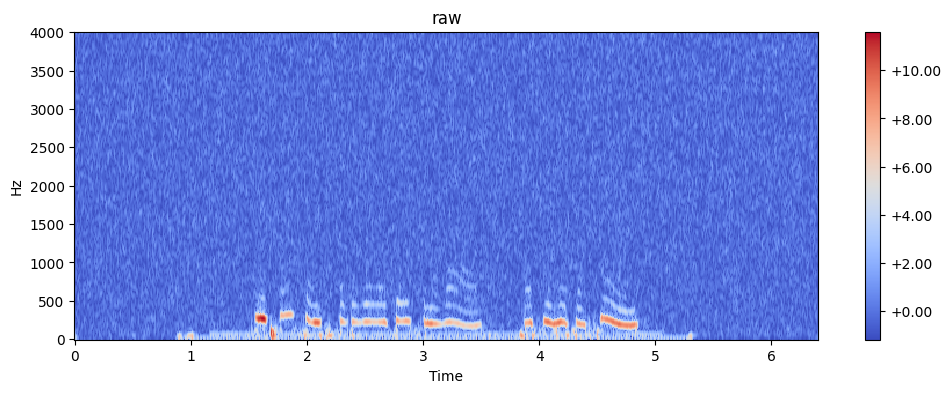

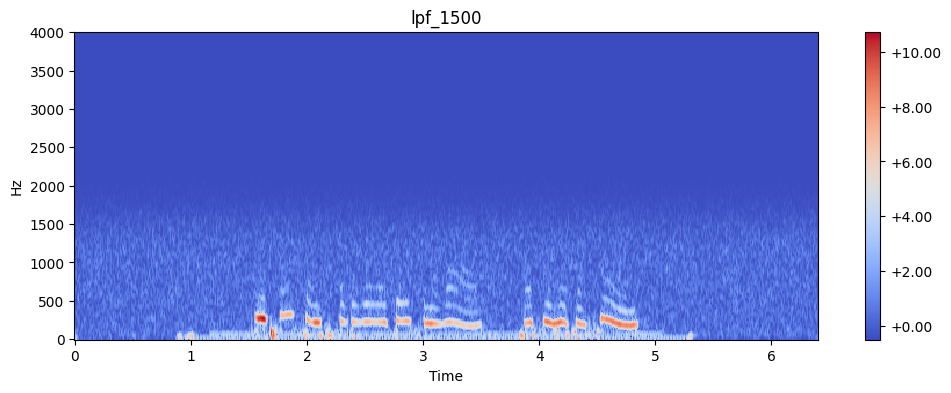

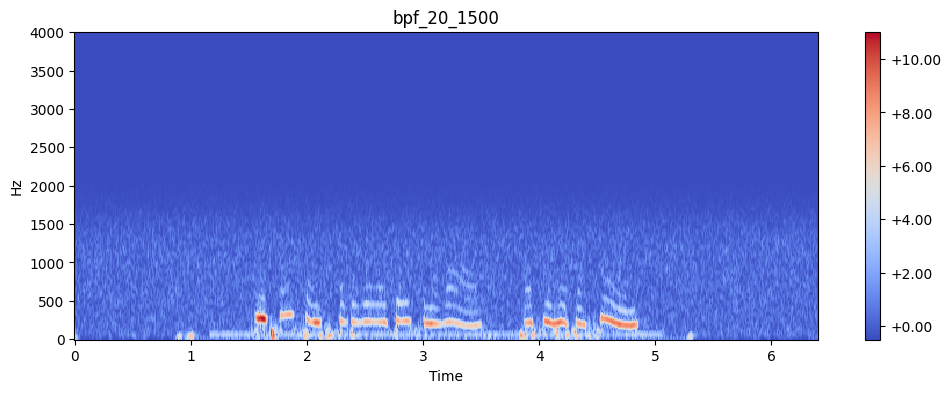

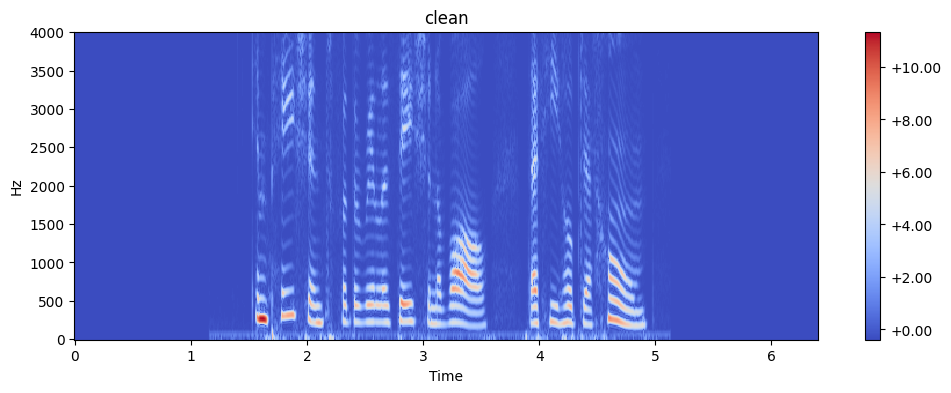

In [36]:
inspect_radar(radar_path)

### DELTA - DELTA

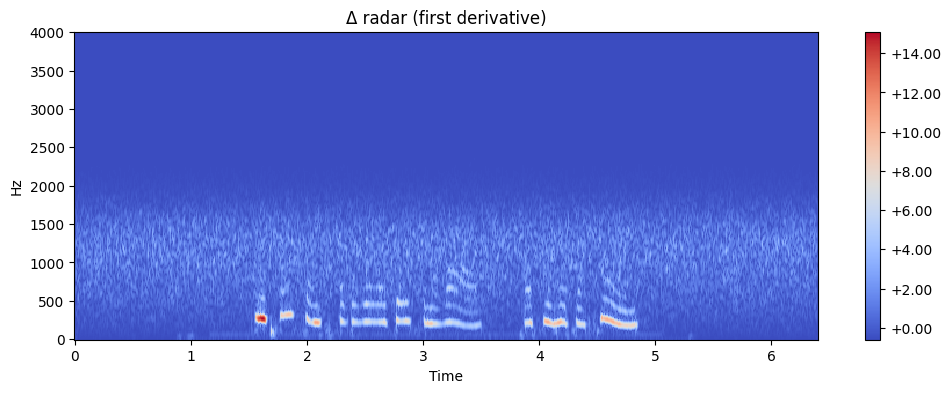

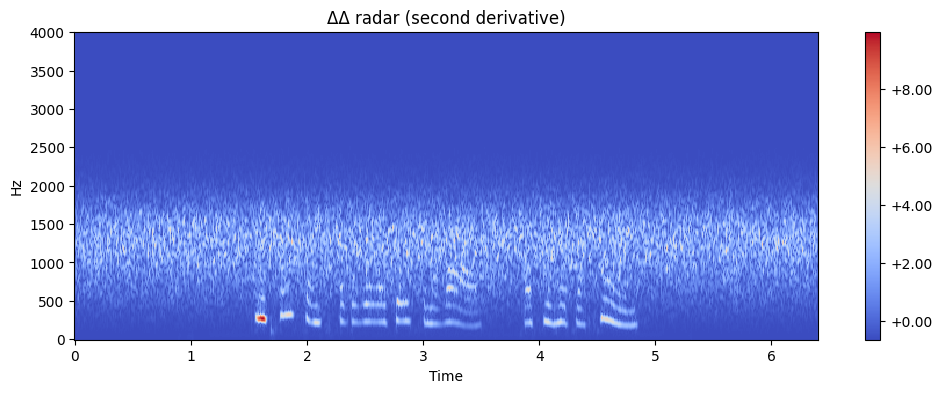

In [41]:
def delta(x):
    return np.concatenate([[0.0], np.diff(x)])

x_d1 = delta(x_lpf)
x_d2 = delta(x_d1)

S_d1, hop_d1 = compute_spec(x_d1, sr)
S_d2, hop_d2 = compute_spec(x_d2, sr)

plot_spec(S_d1, sr, hop_d1, "Δ radar (first derivative)")
plot_spec(S_d2, sr, hop_d2, "ΔΔ radar (second derivative)")

### MULTI RESOLUTION STFT

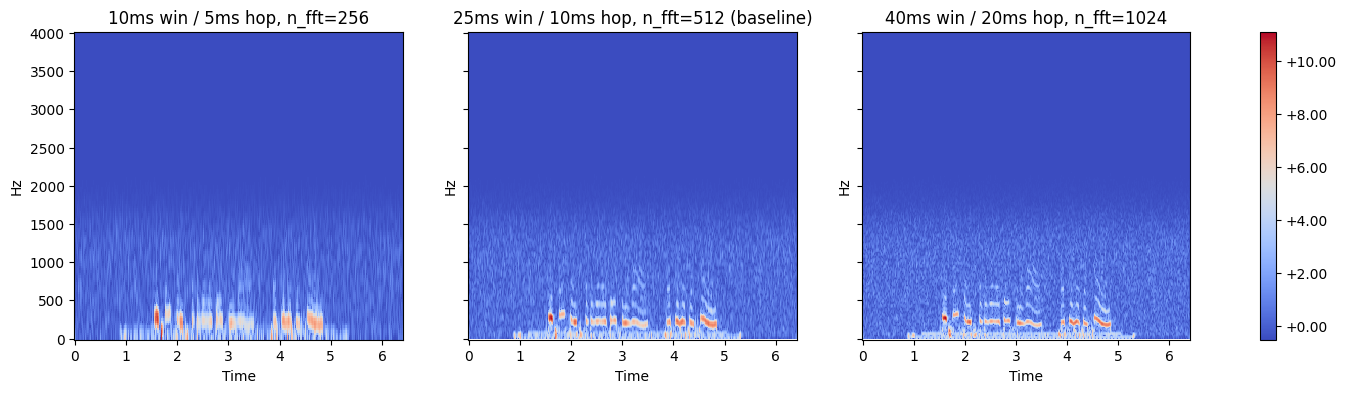

In [43]:
specs = []
params = [
    (10, 5, 256, "10ms win / 5ms hop, n_fft=256"),
    (25,10, 512, "25ms win / 10ms hop, n_fft=512 (baseline)"),
    (40,20,1024, "40ms win / 20ms hop, n_fft=1024")
]

for win_ms, hop_ms, n_fft, label in params:
    S, hop = compute_spec(x_lpf, sr, n_fft=n_fft,
                          win_ms=win_ms, hop_ms=hop_ms)
    specs.append((S, hop, label))

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for ax, (S, hop, label) in zip(axes, specs):
    img = librosa.display.specshow(S, sr=sr, hop_length=hop,
                                   x_axis="time", y_axis="linear", ax=ax)
    ax.set_title(label)
fig.colorbar(img, ax=axes, format="%+0.2f")
plt.show()

### MEL ?

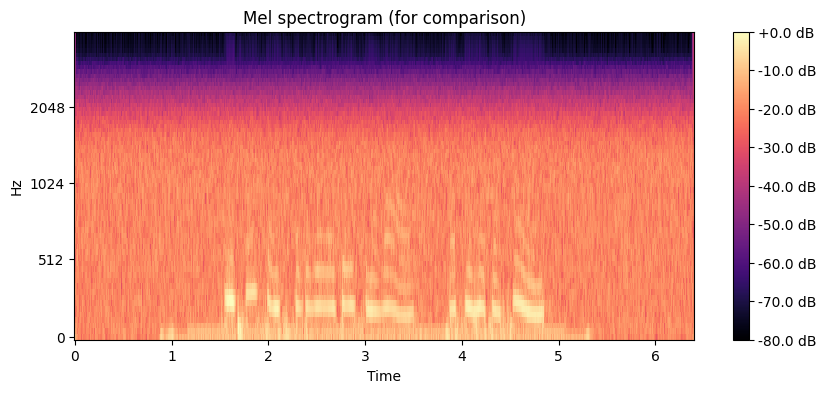

In [45]:
# use the *band-passed* signal
n_fft = 512
hop = int(sr * 10 / 1000)
win = int(sr * 25 / 1000)

S_complex = librosa.stft(x_lpf, n_fft=n_fft,
                         hop_length=hop, win_length=win,
                         window="hann", center=True)
S_mag = np.abs(S_complex)

mel = librosa.feature.melspectrogram(S=S_mag, sr=sr, n_mels=64)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_db, sr=sr, hop_length=hop,
                         x_axis="time", y_axis="mel")
plt.title("Mel spectrogram (for comparison)")
plt.colorbar(format="%+0.1f dB")
plt.show()

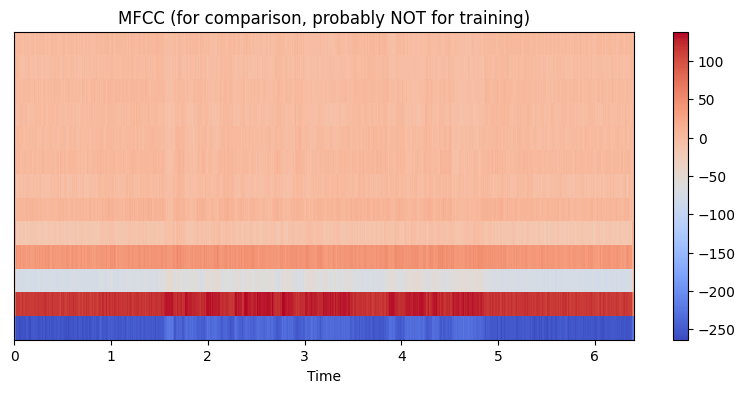

In [46]:
mfcc = librosa.feature.mfcc(S=mel_db, n_mfcc=13)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, sr=sr, hop_length=hop,
                         x_axis="time")
plt.title("MFCC (for comparison, probably NOT for training)")
plt.colorbar()
plt.show()

### PCEN (Per-Channel Energy Normalization) on STFT

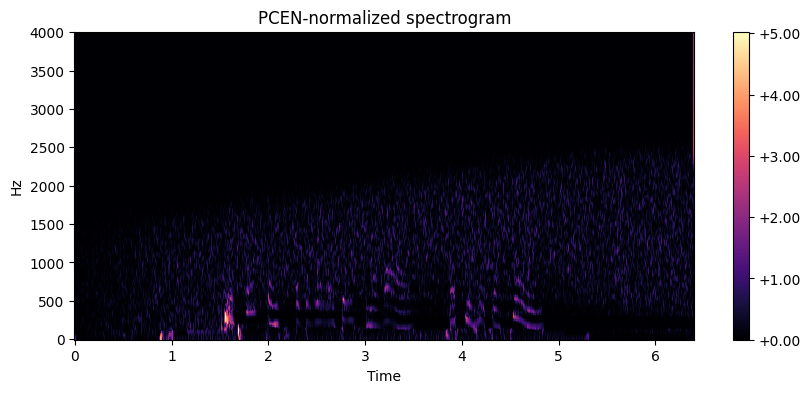

In [48]:
S_mag, hop_pcen = compute_spec(x_lpf, sr, log=False, norm=False)
# librosa.pcen expects power, but magnitude^2 is fine
pcen = librosa.pcen(S_mag**2, sr=sr, hop_length=hop_pcen)

plt.figure(figsize=(10,4))
librosa.display.specshow(pcen, sr=sr, hop_length=hop_pcen,
                         x_axis="time", y_axis="linear")
plt.title("PCEN-normalized spectrogram")
plt.colorbar(format="%+0.2f")
plt.show()

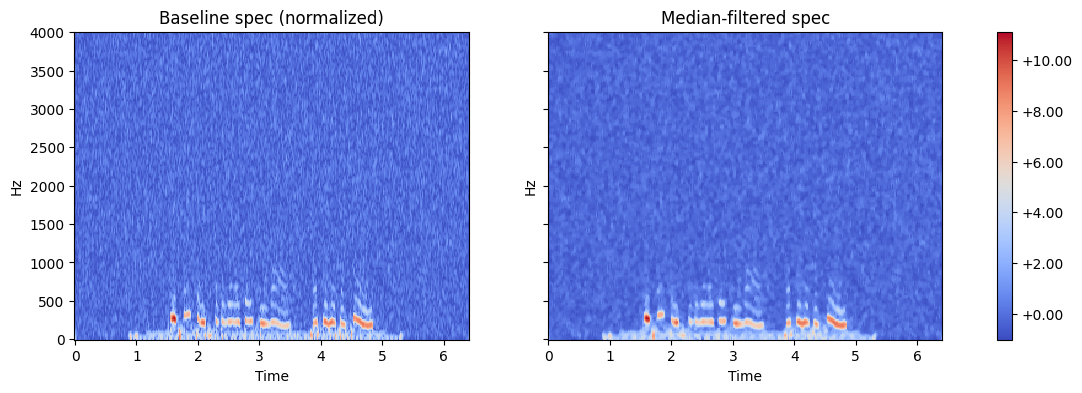

In [52]:
from scipy.ndimage import median_filter

S_clean = median_filter(S_raw, size=(3,3))  # (freq, time)

fig, axes = plt.subplots(1, 2, figsize=(14,4), sharey=True)

librosa.display.specshow(S_raw, sr=sr, hop_length=hop_raw,
                         x_axis="time", y_axis="linear", ax=axes[0])
axes[0].set_title("Baseline spec (normalized)")

img = librosa.display.specshow(S_clean, sr=sr, hop_length=hop_raw,
                               x_axis="time", y_axis="linear", ax=axes[1])
axes[1].set_title("Median-filtered spec")

fig.colorbar(img, ax=axes, format="%+0.2f")
plt.show()

